<a href="https://colab.research.google.com/github/sceddd/TrafficLightVisual/blob/main/detect_and_count_with_roboflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Yolov8 in count object

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
HOME = os.getcwd()

!pip install ultralytics 
!pip install roboflow --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Install requirement lib for supervision

In [3]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack
!pip install -q -r requirements.txt
!pip install thop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112
!pip install -q loguru lap

/content
fatal: destination path 'ByteTrack' already exists and is not an empty directory.
/content/ByteTrack
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.8.0 (from versions: 1.12.0, 1.12.1, 1.13.1, 1.14.0, 1.14.1, 1.15.0)
ERROR: No matching distribution found for onnxruntime==1.8.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import sys
sys.path.append(f"{HOME}/ByteTrack")
import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [5]:
from IPython.display import clear_output
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.114 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.5/107.7 GB disk)


In [6]:
!pip install supervision==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: supervision
    Found existing installation: supervision 0.7.0
    Uninstalling supervision-0.7.0:
      Successfully uninstalled supervision-0.7.0


#Detect Traffic

##ByteTracker preprocessing for YOLOv8

In [7]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [8]:
clear_output()
import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.9.0


In [9]:
# settings
from ultralytics import YOLO
# traffic light detections
MODEL = "/content/drive/MyDrive/best.pt"
TLmodel = YOLO(MODEL)

In [10]:
TLmodel.fuse()
LIGHT_COLOR = TLmodel.model.names

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


In [11]:
#traffic detection
trafficModel = YOLO('yolov8n.pt')
trafficModel.fuse()

YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


In [12]:
CLASS_NAMES_DICT = trafficModel.model.names
CLASS_NAMES_DICT

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [13]:
TRANSPORTATION_ID = [1, 2, 3, 5, 7]
for i in TRANSPORTATION_ID:
  print(CLASS_NAMES_DICT[i])

bicycle
car
motorcycle
bus
truck


##Create header for train dataset

In [14]:
import pandas as pd
from typing import List 
def addHeader(headerList: List[str],filepath:str):
  #read file
  file = pd.read_csv(filepath)
  # converting data frame to csv
  file.to_csv(filepath, header=headerList, index=False)
def writeFile(count_dict: dict, filepath:str):

  return None

In [15]:
header = [
    CLASS_NAMES_DICT[class_id]
    for class_id in TRANSPORTATION_ID
]
header.append('traffic_light_color')
header

['bicycle', 'car', 'motorcycle', 'bus', 'truck', 'traffic_light_color']

In [17]:
import supervision as sv

In [20]:
from typing import List

import numpy as np

# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: sv.Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: sv.Detections, 
    tracks: List[STrack]
) -> sv.Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [28]:
from typing import Dict, Optional 
from typing import Dict
import cv2
import numpy as np
from supervision.geometry.core import  Vector
class LineZoneFixed:
  def __init__(self, start: sv.Point, end: sv.Point,class_id: np.ndarray, grace_period: int = 30):
    self.vector = Vector(start=start, end=end)
    self.tracker_state: Dict[str, bool] = {}
    self.already_counted: Dict[str, bool] = {} # Flag for each tracker_id
    self.current_frame: int = 0 # Current frame counter
    self.class_id:np.ndarray = class_id
    self.grace_period = grace_period # Number of frames to wait before resetting
    self.frame_last_seen: Dict[str, int] = {} # Last frame each tracker_id was encountered
    self.in_count: int = 0
    self.out_count: int = 0
    self.reset_count()
  def is_within_line_segment(self, point: sv.Point, margin: float = 5) -> bool:
    """
    Check if a point is within the line segment.

        Attributes:
            point (Point): The point to be checked.
            margin (float): Additional margin added to the line segment boundaries.

        Returns:
            bool: True if the point is within the line segment, False otherwise.
    """
    x_within = min(self.vector.start.x, self.vector.end.x) - margin <= point.x <= max(self.vector.start.x, self.vector.end.x) + margin
    y_within = min(self.vector.start.y, self.vector.end.y) - margin <= point.y <= max(self.vector.start.y, self.vector.end.y) + margin

    return x_within and y_within
  def reset_count(self):
    self.in_class: Dict[str,int] = {x:0 for x in self.class_id} # Count objects in
    self.out_class: Dict[str,int] = {x:0 for x in self.class_id} # Count objects out
    
    
  def trigger(self, detections: sv.Detections) -> np.ndarray:
    self.current_frame += 1  # Increment frame counter
    for xyxy, _, confidence, class_id, tracker_id in detections:
      # handle detections with no tracker_id
      if tracker_id is None:
        continue

      # we check if the bottom center anchor of bbox is on the same side of vector
      x1, y1, x2, y2 = xyxy
      anchor = sv.Point(x=(x1+x2)/2, y=y2)  # Bottom center point of bounding box

      # Check if anchor is within the line segment
      if not self.is_within_line_segment(anchor,10):
        continue

      tracker_state = self.vector.is_in(point=anchor)

      # handle new detection
      if tracker_id not in self.tracker_state:
        self.tracker_state[tracker_id] = tracker_state
        self.already_counted[tracker_id] = False  # When the object appears, it has not been counted yet
        self.frame_last_seen[tracker_id] = self.current_frame  # Update last seen frame
        continue

      # handle detection on the same side of the line
      if self.tracker_state.get(tracker_id) == tracker_state:
        continue

      # check if this crossing has already been counted
      if self.already_counted.get(tracker_id, False):  # If it has been counted, we skip this
          # Check if grace period has passed since last encounter
        if self.current_frame - self.frame_last_seen.get(tracker_id, 0) > self.grace_period:
            self.already_counted[tracker_id] = False  # Reset after grace period
        else:
            continue

      self.tracker_state[tracker_id] = tracker_state
      self.already_counted[tracker_id] = True  # After counting, we mark this crossing as already counted
      self.frame_last_seen[tracker_id] = self.current_frame  # Update last seen frame
      if tracker_state:
        self.in_class[class_id] += 1
      else:
        self.out_class[class_id] +=1
    self.in_count = sum(self.in_class.values())
    self.out_count = sum(self.out_class.values())

In [22]:
#source to choose video
SOURCE_VIDEO_PATH = f"/content/drive/MyDrive/Camera-Giao-Thong/14-05-2023/camera1.mp4"
OUTPUT_VIDEO_PATH = f"/content/drive/MyDrive/Camera-Giao-Thong/output/vehicle-counting-result.mp4"
video_info = sv.VideoInfo.from_video_path(video_path = SOURCE_VIDEO_PATH)

##Create lines object for detect multiple lines

In [23]:
#TODO: detect road surface marking to draw line
#line position
LINES = [[sv.Point(220, 310),sv.Point(850, 310)]]


In [29]:
color = sv.ColorPalette.default()
lines = [
    LineZoneFixed(start=x,end=y,class_id = TRANSPORTATION_ID)
    for x,y
    in LINES
]
lines_annotator = [
    sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=2)
    for index in range(len(lines))
]
box_annotator = sv.BoxAnnotator(thickness = 1, text_thickness = 2,text_scale=2)
byte_tracker = BYTETracker(BYTETrackerArgs())
trafficLight_annotator = sv.BoxAnnotator(thickness = 1,text_thickness = 2,text_scale =2)

In [30]:
def reset(path:str = SOURCE_VIDEO_PATH):
  generator = sv.get_video_frames_generator(path)
  iterator = iter(generator)
  frame = next(iterator)
  return frame
frame = reset()

In [ ]:
for line,line_att in zip(lines,lines_annotator):
  line_att.annotate(frame=frame,line_counter=line)
sv.plot_image(frame)

##Detect traffic light

In [24]:
def crop_image(image: np.ndarray, xyxy: np.ndarray) -> List[np.ndarray]:
  xyxy = [round(elem) for elem in xyxy ]
  x1,y1,x2,y2 = xyxy
  cropped_image = image[y1:y2,x1:x2]
  return cropped_image

def detect_color(frame:np.ndarray,xyxy:np.ndarray) -> str:
  """
  Detect traffic light's color

  Args:
  frame(np.ndarray): The image contain the detections to check it color
  xyxy (np.ndarray): An array of shape `(n, 4)` containing the bounding boxes coordinates in format `[x1, y1, x2, y2]`
  """
  cropped = crop_image(frame,xyxy)
  hsv_frame = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)

  red_lower = np.array([0, 100, 100])
  red_upper = np.array([30, 255, 255])
  green_lower = np.array([40, 100, 100])
  green_upper = np.array([100, 255, 255])

  red_mask = cv2.inRange(hsv_frame, red_lower, red_upper)
  green_mask = cv2.inRange(hsv_frame, green_lower, green_upper)

  red_pixels = np.count_nonzero(red_mask)
  green_pixels = np.count_nonzero(green_mask)

  color_counts = {
      "Red": red_pixels,
      "Green": green_pixels,
  }

  color_counts_filtered = {color: count for color, count in color_counts.items() if count > 0}
  if len(color_counts_filtered)>0:
    return max(color_counts_filtered, key=color_counts_filtered.get)
  else: return None
def process_trafficLight(frame:np.ndarray,TF_detections:sv.Detections)->np.ndarray:
  """
    Check objects color:
    
    Args:
    TF_detections(Detections): Traffic light detections to check colors
  """
  colors = []
  for detect in TF_detections:
    if isinstance(detect, tuple):
      bbox = detect[0] 
    else:
      bbox = detect.bbox  
    colors.append(detect_color(frame, bbox))
  return max(colors,key=colors.count)

In [33]:
def process_transportation(frame: np.ndarray, i) -> np.ndarray:
    global prevcolor,change_color
    # detect trafficlight
    TF_results = TLmodel(frame)[0]
    TF_detections = sv.Detections.from_yolov8(TF_results)
    
    #detect transportation
    TP_results = trafficModel(frame)[0]
    TP_detections = sv.Detections.from_yolov8(TP_results)
    
    type_mask = np.array([class_id in TRANSPORTATION_ID for class_id in detections.class_id], dtype=bool)
    detections = detections[type_mask]

    #merge detection for annotate
    detections = sv.Detections.merge([detections,TF_detections])

    # tracking detections
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
    detections.tracker_id = np.array(tracker_id)

    # filtering out detections without trackers
    tracker_mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
    detections = detections[tracker_mask]
    
     #detections label
    labels = [
        f"{tracker_id}"
        for _,_,_,_,tracker_id in detections
    ]
    # annotate and display frame
    frame = box_annotator.annotate(scene=frame,detections=detections,labels = labels)

    if i%video_info.fps != 0:   # get frame by sec
      color = process_trafficLight(frame,detections[detections.class_id == 0])  # color 
      sec = int(i/video_info.fps)
      change_color = prevcolor != color
      if change_color:
        prevcolor = color
        

    for line,line_annotator in zip(lines,lines_annotator):
      # setting lines
      if change_color:  #reset line count if the traffic light switch color
        line.reset_count()
        change_color = False
  
      line.trigger(detections = detections)
      frame = line_annotator.annotate(frame=frame,line_counter=line)
    # check traffic light color every sec
    
    return frame

#Detect and count object

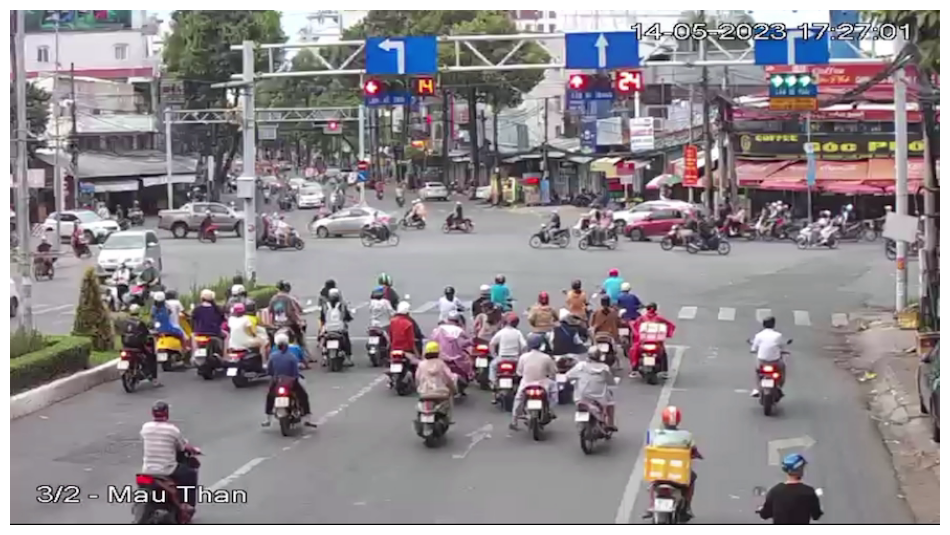


0: 448x800 4 traffic lights, 635.1ms
Speed: 26.5ms preprocess, 635.1ms inference, 2.0ms postprocess per image at shape (1, 3, 800, 800)


In [34]:
video_capture = cv2.VideoCapture(SOURCE_VIDEO_PATH)
#setting the time
video_capture.set(cv2.CAP_PROP_POS_MSEC,42*1000)   
success,image = video_capture.read()
sv.plot_image(image)
if success:
  TF_results = TLmodel(image)[0]
  TF_detections = sv.Detections.from_yolov8(TF_results)

In [36]:
change_color = False
prevcolor = 'Red'
process_transportation(image,1)


0: 384x640 8 persons, 6 cars, 154.7ms
Speed: 3.4ms preprocess, 154.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 448x800 2 traffic lights, 547.0ms
Speed: 4.6ms preprocess, 547.0ms inference, 1.0ms postprocess per image at shape (1, 3, 800, 800)


array([[[127, 110, 117],
        [143, 126, 133],
        [142, 126, 131],
        ...,
        [ 15,  45,  44],
        [ 14,  45,  42],
        [ 16,  47,  44]],

       [[128, 111, 118],
        [143, 126, 133],
        [146, 130, 135],
        ...,
        [  9,  39,  38],
        [  9,  40,  37],
        [ 18,  49,  46]],

       [[129, 112, 119],
        [143, 126, 133],
        [147, 130, 137],
        ...,
        [ 10,  40,  39],
        [ 12,  42,  41],
        [ 30,  60,  59]],

       ...,

       [[144, 140, 145],
        [144, 140, 145],
        [144, 140, 145],
        ...,
        [137, 140, 156],
        [138, 141, 157],
        [138, 141, 157]],

       [[113, 112, 114],
        [113, 112, 114],
        [113, 112, 114],
        ...,
        [118, 119, 126],
        [118, 119, 126],
        [118, 119, 126]],

       [[  0,   0,   1],
        [  0,   0,   1],
        [  0,   0,   1],
        ...,
        [  0,   0,   4],
        [  0,   0,   5],
        [  0,   0,   5]]

In [37]:
change_color = False
prevcolor = process_trafficLight(frame,TF_detections)
sv.process_video(source_path=SOURCE_VIDEO_PATH, target_path=OUTPUT_VIDEO_PATH, callback=process_transportation)

NameError: ignored

#Detect objects and count with polygon

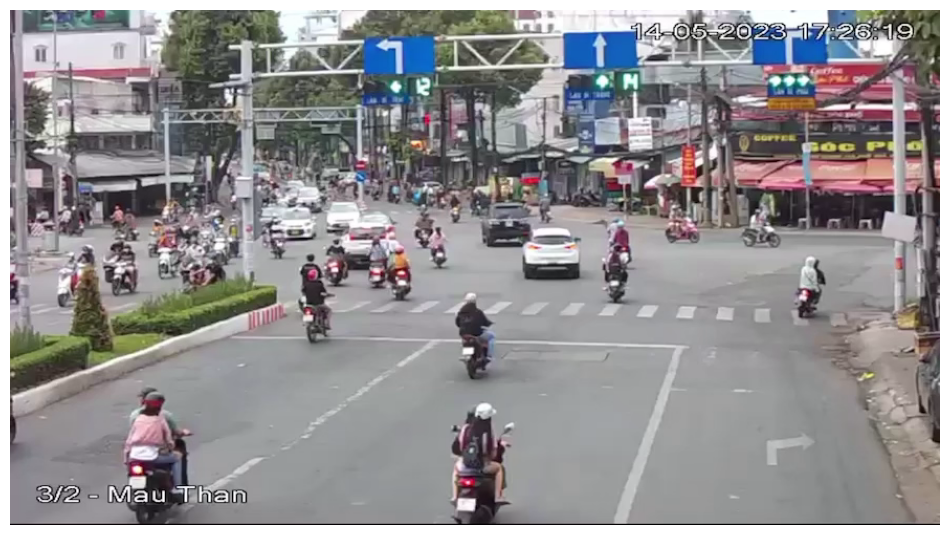

In [58]:
frame = reset()
sv.plot_image(frame)

In [59]:
#create polygone
polygon = np.array([
    [220, 310],
    [850, 310],
    [850,400],
    [50,400]  ,
])



0: 384x640 9 persons, 7 cars, 13 motorcycles, 182.7ms
Speed: 5.5ms preprocess, 182.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


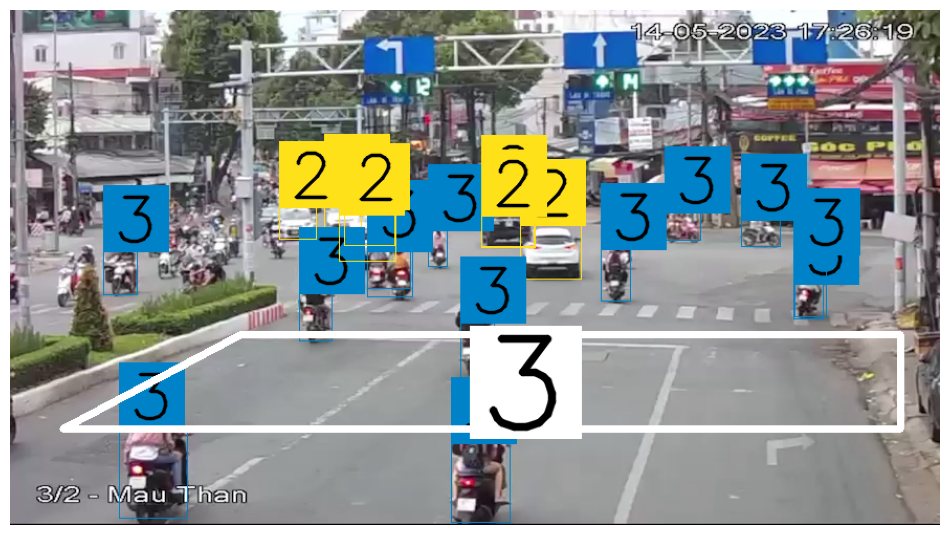

In [60]:
zone = sv.PolygonZone(polygon = polygon,frame_resolution_wh=video_info.resolution_wh)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

TP_results = trafficModel(frame)[0]
TP_detections = sv.Detections.from_yolov8(TP_results)
    
type_mask = np.array([class_id in TRANSPORTATION_ID for class_id in TP_detections.class_id], dtype=bool)
detections = TP_detections[type_mask]
zone.trigger(TP_detections)
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = zone_annotator.annotate(scene=frame)
sv.plot_image(frame)
# def testPolygon(frame:np.ndarray,i):
#   results = trafficModel(frame)[0]
#   detections = Detections.from_yolov8(results)
  
